In [1]:
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans

from utils.hash import make
from utils.calculate_pmi_features import get_data, run_PMI

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
df = get_data()
df.ethnicity.fillna('', inplace=True)
df['ethnicity_'] = df.ethnicity.apply(lambda x: 'mixed' if ',' in x else x)

In [3]:
X = make(run_PMI, 'calculate_pmi_features.py', {'p' : 'datamatrix.pkl'})

datamatrix.pkl exists
the hash for datamatrix.pkl matches what's in hashes.json
checking whether the script has been updated...
it hasn't; loading datamatrix.pkl


In [4]:
K = 4

mb_kmeans = MiniBatchKMeans(n_clusters=K, random_state=1868)
mb_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=3, random_state=1868, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [5]:
df['kmeans'] = mb_kmeans.labels_

In [6]:
df.kmeans.value_counts().sort_index()

0       37
1    35882
2       21
3    21882
dtype: int64

In [7]:
df['token_count'] = df.TotalEssays.str.split().str.len()

In [8]:
df.groupby('kmeans')['token_count'].mean()

kmeans
0     12.918919
1    367.024441
2      5.666667
3    375.849831
Name: token_count, dtype: float64

In [9]:
low = df[df.kmeans.isin([0, 2])][['TotalEssays', 'token_count', 'kmeans']]
low.reset_index(drop=True, inplace=True)

In [10]:
for c in np.sort(df.kmeans.unique()):
    if c == 0:
        tdf = df[df.kmeans == c]
        tdf_p = pd.DataFrame({str(c) :
                              tdf.ethnicity_.value_counts().sort_index()/\
                              tdf.ethnicity_.value_counts().sort_index().sum()}).reset_index()
    else:
        tdf = df[df.kmeans == c]
        tdf_p = pd.merge(tdf_p,
                         pd.DataFrame({str(c) :
                                       tdf.ethnicity_.value_counts().sort_index()/\
                                       tdf.ethnicity_.value_counts().sort_index().sum()}).reset_index(),
                         how='outer',
                         on='index')

tdf_p.fillna(0)
tdf_p.rename(columns={'index':'ethnicity_'}, inplace=True)
tdf_p.sort('ethnicity_', inplace=True)
tdf_p.reset_index(drop=True, inplace=True)

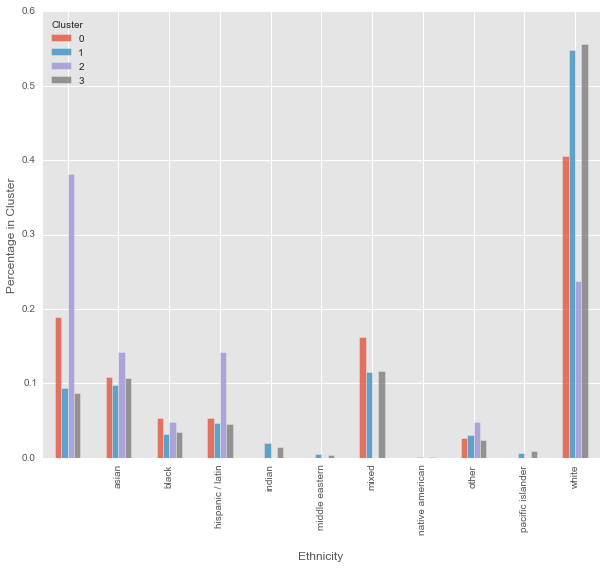

In [11]:
tdf_p.plot(alpha=0.75, figsize=(10, 8), kind='bar')

plt.xlim(-0.5, len(df.ethnicity_.unique())-0.5)
plt.xticks(tdf_p.index, tdf_p.ethnicity_, rotation=90);

plt.xlabel('\nEthnicity')
plt.ylabel('Percentage in Cluster')

plt.legend(range(K), loc='upper left', title='Cluster')